In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sys
from tqdm import trange
%load_ext line_profiler

from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib.widgets import Slider, Button

In [2]:
def plot_cubes(matrix):
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(matrix,edgecolor='k')

In [3]:
def add_cube(matrix):
    pad_matrix = np.pad(matrix,1)
    conv = np.array([[[0,0,0],[0,1,0],[0,0,0]]
                     ,[[0,1,0],[1,-10,1],[0,1,0]]
                     ,[[0,0,0],[0,1,0],[0,0,0]]])

    places = scipy.ndimage.convolve(pad_matrix,conv,mode='constant',cval=0)
    
    new_matrices = []
    for idx in np.argwhere(places>0):
        new_mat = pad_matrix.copy()
        new_mat[tuple(idx)] = 1
        new_matrices.append(new_mat)
    return new_matrices

In [66]:
def get_distances(matrix,n:int=None):
    dist_mat = scipy.spatial.distance_matrix(np.argwhere(matrix==1),np.argwhere(matrix==1))
    if not n:
        n = dist_mat.shape[0]
    distances = np.sort(dist_mat[np.triu_indices(n,k=1)])[::-1]
    d = distances.copy(order='C')
    # d.flags.writeable = False
    return d

In [43]:
def check_chiral(matrix):
    reflection = matrix[::-1].copy()
    matrix = shift_to_origin(matrix)

    rots = 
    
    if (np.array_equal(matrix, reflection_x)) | (np.array_equal(matrix, reflection_y))| (np.array_equal(matrix, reflection_z )):
        return False
    else:
        return True

def shift_to_origin(matrix):
    while not matrix[0,:,:].any():
        matrix = np.roll(matrix,-1,axis=0)
    while not matrix[:,0,:].any():
        matrix = np.roll(matrix,-1,axis=1)
    while not matrix[:,:,0].any():
        matrix = np.roll(matrix,-1,axis=2)
    return matrix

In [157]:
def add_n(df):
    nmax = df.n.max()
    new_df = pd.DataFrame(
        columns=[
            'id',
            'n',
            'matrix',
            'distances',
            'chiral',
            'id_from'
        ],
    )

    new_df['matrix'] = df.loc[df.n==nmax].matrix.apply(add_cube)
    new_df['id_from'] = df.loc[df.n==nmax]['id']
    new_df['id_from'] = df.id_from.apply(lambda x: [x])
    
    new_df = new_df.explode('matrix')
    
    new_df['distances'] = new_df.matrix.apply(get_distances)
    new_df['id'] = new_df.distances.apply(lambda x: hash(x.data.tobytes()))
    
    new_df2 = new_df.groupby(['id']).first()
    new_df2['id_from'] = new_df.groupby(['id']).id_from.sum()
    
    new_df2.reset_index(inplace=True)
    new_df2['n'] = nmax+1
    
    df = pd.concat([df,new_df2],axis=0,ignore_index=True)
    return df

In [158]:
df0 = pd.DataFrame(
    columns=[
        'id',
        'n',
        'matrix',
        'distances',
        'chiral',
        'id_from'
    ],
    )
df0.loc[len(df0)] =  {
    
    'id':  hash(str(np.array([0]))),
    'n': 1,
    'matrix': np.array(
                        [[[1]]]
                        ,dtype='int8'
                        ),
    'distances': np.array([0]) ,
    'chiral': False
}

In [159]:
def add_till_n(n,df = df0):
    last_n = df.n.max()
    for i in trange(n-last_n):
        df = add_n(df)
    return df

In [160]:
df = add_till_n(7)

100%|██████████| 6/6 [00:00<00:00, 14.92it/s]


In [165]:
df[df.n==2]

,id,n,matrix,distances,chiral,id_from
1,-68145560200888465,2,"[[[0, 0, 0], [0, 1, 0], [0, 0, 0]], [[0, 0, 0]...",[1.0],None,"[nan, nan, nan, nan, nan, nan]"


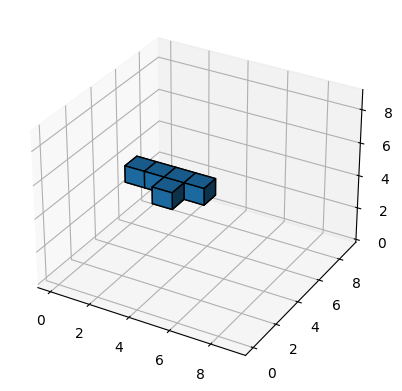

In [111]:
next_cubes = df.loc[df.id_from==2005010117641958287,'matrix'].to_numpy()
plot_cubes(df.loc[df.id==2005010117641958287,'matrix'].to_numpy()[0])

In [119]:
add_cube(df.loc[df.id==2005010117641958287,'matrix'].to_numpy()[0])

20

In [99]:
n = 5
ids = df.loc[df.n==n].id.tolist()
vals = df.loc[df.n==n].matrix.tolist()

@interact(x=(0,len(vals)-1))
def plot(x):
    print(ids[x])
    plot_cubes(vals[x])

interactive(children=(IntSlider(value=10, description='x', max=20), Output()), _dom_classes=('widget-interact'…